In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pew_metadata_path = '../dataset/pew_dataset/metadata.csv'

# Load the metadata from the Pew dataset
pew_data = pd.read_csv(pew_metadata_path)
# Drop all columns except 'title' and topic'
pew_data = pew_data[['title', 'topic']]

In [2]:
# Get the distinct list of sectors
distinct_sectors = pew_data['topic'].dropna().unique().tolist()
distinct_sectors

['Hispanic Trends',
 'Journalism & Media',
 'Internet & Technology',
 'Social & Demographic Trends',
 'Global Attributes & Trends',
 'Methods',
 'U.S. Politics & Policy',
 'Coronavirus Disease (COVID-19)',
 'Science & Society',
 'Economy & Work',
 'Uncategorised',
 'Religion & Public Life']

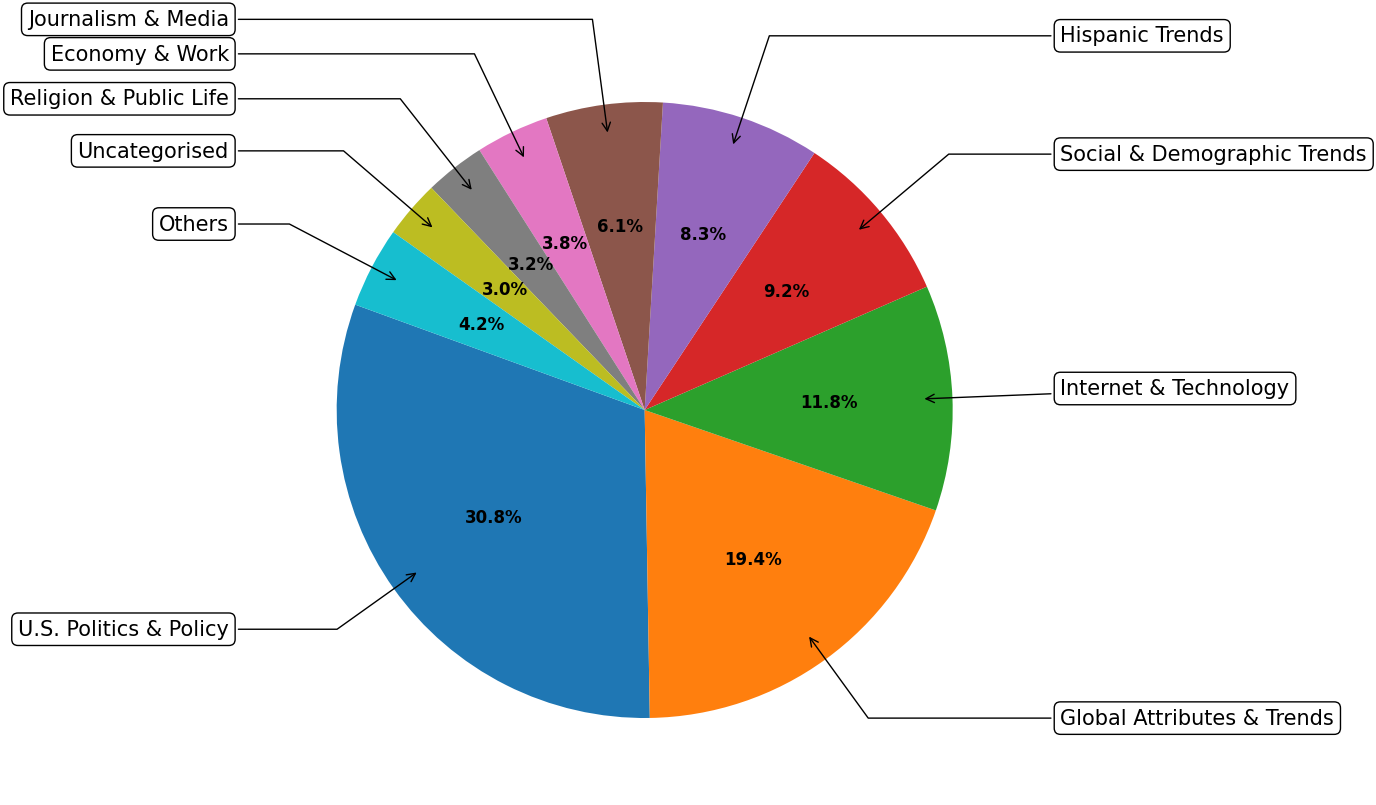

In [3]:
# Count the occurrences of each topic
topic_counts = pew_data['topic'].value_counts()

# Combine small segments (<3%) into 'Others'
total = topic_counts.sum()
threshold = 0.03 * total
large_slices = topic_counts[topic_counts > threshold]
small_slices = topic_counts[topic_counts <= threshold]

# Combine small slices into an 'Others' category
if not small_slices.empty:
    large_slices['Others'] = small_slices.sum()

# Prepare data for plotting
labels = large_slices.index
sizes = large_slices.values

# Colors for each section
colors = plt.get_cmap('tab10').colors

# Create a pie chart
fig, ax = plt.subplots(figsize=(16, 10))
wedges, texts, autotexts = ax.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=160)

# Add annotations with pointers (leader lines)
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * 0.9 * np.cos(np.radians(angle))
    y = wedge.r * 0.9 * np.sin(np.radians(angle))

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={angle}"

    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=15,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

plt.setp(autotexts, size=12, weight="bold", color="black")

# Save the pie chart to the dataset folder
image_path = '../dataset/pew_dataset/pew_topic_distribution.png'
plt.savefig(image_path)

plt.show()

In [4]:
from dataProcessor import clean_text, correct_misinterpreted_characters
sta_metadata_path = '../dataset/statista_dataset/metadata.csv'
# Load the metadata from the Pew dataset
sta_data = pd.read_csv(sta_metadata_path)
# Drop all columns except 'title' and topic'
sta_data = sta_data[['title', 'caption']]
sta_data['title'] = sta_data['title'].apply(clean_text).apply(correct_misinterpreted_characters)
sta_data['caption'] = sta_data['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
sta_data

,title,caption
0,Number of monthly active Facebook users worldw...,How many users does Facebook have? With over 2...
1,United States: estimated net worth of the 20 r...,This statistic presents the estimated net wort...
2,Reported violent crime rate in the United Stat...,This statistic shows the reported violent crim...
3,Players with the most rushing yards in NFL his...,Emmitt Smith is the all-time rushing leader of...
4,Players with most goals in the UEFA Champions ...,"As of July 2020, Cristiano Ronaldo leads the U..."
...,...,...
27863,Distribution of cyber stalking victims in 2013...,This statistic presents the distribution of cy...
27864,Total number of dwellings in Great Britain fro...,This statistic displays the total number of dw...
27865,Results in the European Parliament elections i...,This statistic shows the political parties and...
27866,Average annual expenditure on curtains and dra...,This statistic shows the average annual expend...


In [6]:
def context(title, caption):
    # string concatenation without including the plus signs in the final string
    combined_text = f"{title}. {caption}"
    description = combined_text
    return description


In [7]:
# Create an OpenAI client with your deepinfra token and endpoint
from openai import OpenAI
openai = OpenAI(
    api_key="dfdgdfgfhgghguzuummmSSDDDsOvywvkOllcPHEBGP1",
    base_url="https://api.deepinfra.com/v1/openai",
)

In [8]:
def classify_topic(context):
    response = openai.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an AI assistant. Your task is to classify the following text into one of the "
                    "topics from this list: 'Hispanic Trends', 'Journalism & Media', 'Internet & Technology', "
                    "'Social & Demographic Trends', 'Global Attributes & Trends', 'U.S. Politics & Policy', "
                    "'Coronavirus Disease (COVID-19)', 'Science & Society', 'Economy & Work', 'Uncategorised','Religion & Public Life'"
                    " Please Strictly only provide the name of the topic, and nothing else."
                ),
            },
            {"role": "user", "content": context}
        ],
    )
    topic = (response.choices[0].message.content)
    return topic


In [10]:
from tqdm import tqdm

# Initialize a list to store the classified topics
topics = []

# Loop through each row in the DataFrame
for index, row in tqdm(sta_data.iterrows(), total=sta_data.shape[0], desc="Processing Rows"):
    content = context(row['title'], row['caption']) 
    # Classify the topic based on the content
    topic = classify_topic(content)
    topics.append(topic)

# Add the classified topics to the DataFrame, if needed
sta_data['topic'] = topics

Processing Rows: 100%|██████████| 27868/27868 [3:32:04<00:00,  2.19it/s]   


In [11]:
sta_data

,title,caption,topic
0,Number of monthly active Facebook users worldw...,How many users does Facebook have? With over 2...,Internet & Technology
1,United States: estimated net worth of the 20 r...,This statistic presents the estimated net wort...,Economy & Work
2,Reported violent crime rate in the United Stat...,This statistic shows the reported violent crim...,U.S. Politics & Policy
3,Players with the most rushing yards in NFL his...,Emmitt Smith is the all-time rushing leader of...,Uncategorised
4,Players with most goals in the UEFA Champions ...,"As of July 2020, Cristiano Ronaldo leads the U...",Uncategorised
...,...,...,...
27863,Distribution of cyber stalking victims in 2013...,This statistic presents the distribution of cy...,Internet & Technology
27864,Total number of dwellings in Great Britain fro...,This statistic displays the total number of dw...,Social & Demographic Trends
27865,Results in the European Parliament elections i...,This statistic shows the political parties and...,U.S. Politics & Policy
27866,Average annual expenditure on curtains and dra...,This statistic shows the average annual expend...,Economy & Work


In [12]:
# Function to check if any part of the sentence matches a topic in the list
def align_title_with_topic(sentence, topics_list):
    # Convert sentence to lowercase for case-insensitive matching
    sentence_lower = sentence.lower()
    
    # Check if any part of the sentence matches a topic in the list
    for topic in topics_list:
        if topic.lower() in sentence_lower:
            return topic
    
    # If no match is found, return 'Uncategorised'
    return 'Uncategorised'

In [13]:
sta_data['aligned_topic'] = sta_data['topic'].apply(lambda sentence: align_title_with_topic(sentence, distinct_sectors))

# Saving the updated DataFrame to a CSV file
sta_data.to_csv('../dataset/sta_data_aligned_topics.csv', index=False)

# Output the first few rows of the updated DataFrame
sta_data.head()

,title,caption,topic,aligned_topic
0,Number of monthly active Facebook users worldw...,How many users does Facebook have? With over 2...,Internet & Technology,Internet & Technology
1,United States: estimated net worth of the 20 r...,This statistic presents the estimated net wort...,Economy & Work,Economy & Work
2,Reported violent crime rate in the United Stat...,This statistic shows the reported violent crim...,U.S. Politics & Policy,U.S. Politics & Policy
3,Players with the most rushing yards in NFL his...,Emmitt Smith is the all-time rushing leader of...,Uncategorised,Uncategorised
4,Players with most goals in the UEFA Champions ...,"As of July 2020, Cristiano Ronaldo leads the U...",Uncategorised,Uncategorised


In [16]:
# Get the distinct list of topics
distinct_topics = sta_data['aligned_topic'].dropna().unique().tolist()
distinct_topics

['Internet & Technology',
 'Economy & Work',
 'U.S. Politics & Policy',
 'Uncategorised',
 'Coronavirus Disease (COVID-19)',
 'Global Attributes & Trends',
 'Social & Demographic Trends',
 'Science & Society',
 'Hispanic Trends',
 'Journalism & Media',
 'Religion & Public Life']

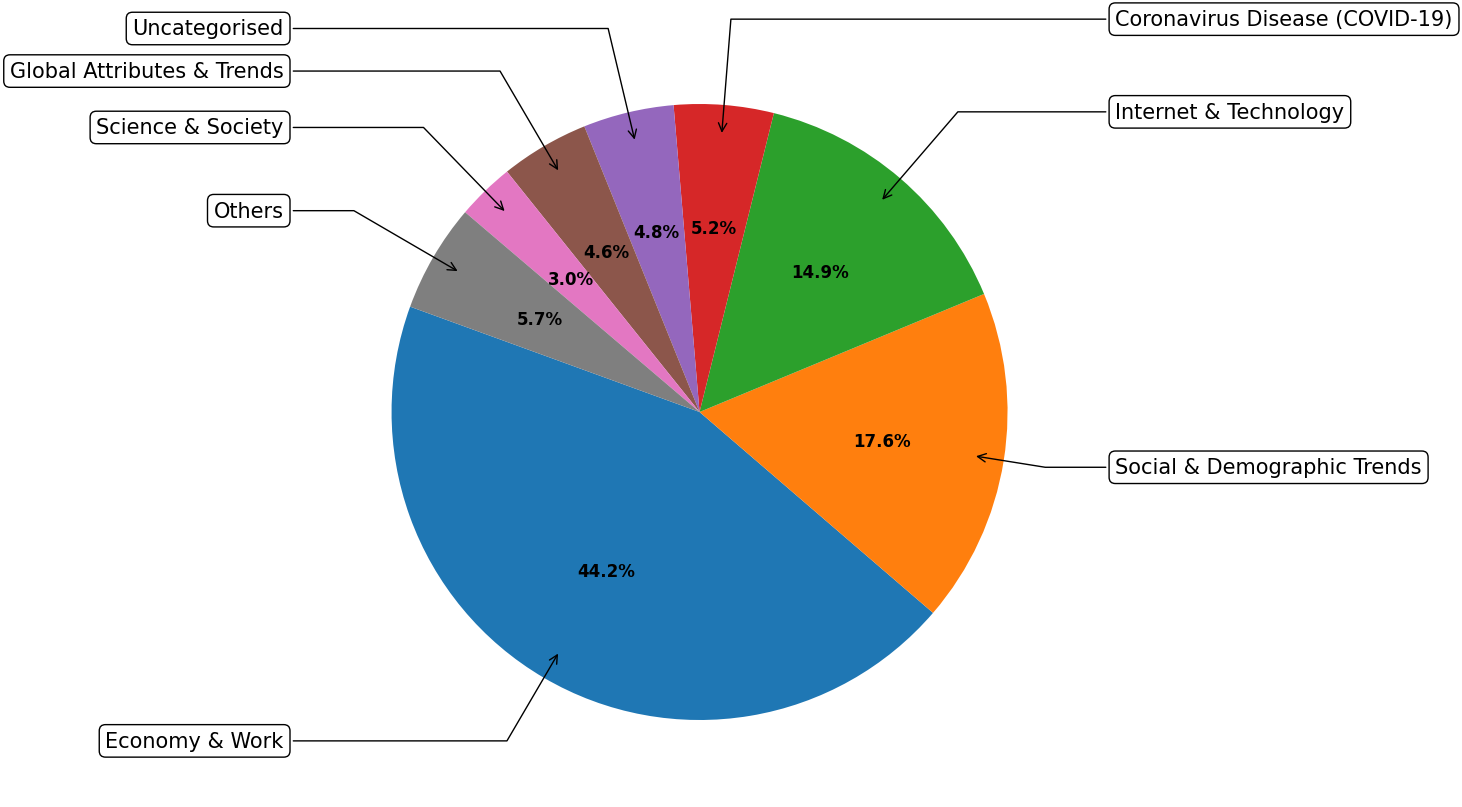

In [17]:
# Count the occurrences of each topic
topic_counts = sta_data['aligned_topic'].value_counts()

# Combine small segments (<3%) into 'Others'
total = topic_counts.sum()
threshold = 0.03 * total
large_slices = topic_counts[topic_counts > threshold]
small_slices = topic_counts[topic_counts <= threshold]

# Combine small slices into an 'Others' category
if not small_slices.empty:
    large_slices['Others'] = small_slices.sum()

# Prepare data for plotting
labels = large_slices.index
sizes = large_slices.values

# Colors for each section
colors = plt.get_cmap('tab10').colors

# Create a pie chart
fig, ax = plt.subplots(figsize=(16, 10))
wedges, texts, autotexts = ax.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=160)

# Add annotations with pointers (leader lines)
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * 0.9 * np.cos(np.radians(angle))
    y = wedge.r * 0.9 * np.sin(np.radians(angle))

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={angle}"

    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=15,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

plt.setp(autotexts, size=12, weight="bold", color="black")

# Save the pie chart to the dataset folder
image_path = '../dataset/statista_dataset/sta_topic_distribution.png'
plt.savefig(image_path)

plt.show()